In [1]:
!nvidia-smi

Sun Dec 13 18:39:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:03:00.0 Off |                  N/A |
| 41%   59C    P2    68W / 280W |   3954MiB / 24219MiB |      6%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:04:00.0 Off |                  N/A |
| 40%   37C    P8     5W / 280W |   5710MiB / 24220MiB |      9%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets
from torchvision import transforms

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [4]:
#также будем использовать аугментацию: рандомные повороты на 7 градусов и отражение относительно вертикали.

#преобразование трейна
train_tf = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(7),
    transforms.ToTensor()
])

#тест не меняем
test_tf = transforms.Compose([
    transforms.ToTensor()
])

train = torchvision.datasets.CIFAR10('./', download=True, train=True, transform=train_tf)
test = torchvision.datasets.CIFAR10('./', download=True, train=False, transform=test_tf)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:1


In [6]:
# data loader
trainloader = torch.utils.data.DataLoader(train, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(test, batch_size = 256, shuffle = False)

In [7]:
import torchvision.models as models
model = models.vgg16(pretrained=True)
#model = models.resnet18(pretrained=True)
model = model.to(device)

In [8]:
#В качестве лоса возмем кросс-энтропию. Оптимизатор - Адам
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

#добавим уменьшение лернинг рейта, если выходим на плато. Это решение будем принимать по валидационной выборке.
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=7, factor=0.2)

In [9]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [10]:
def train(epoch):
    running_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
    len_train = 0.0
    len_test = 0.0
    
    loss_train = 0.0
  
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss_val = loss(outputs, targets)
        loss_val.backward()
        optimizer.step()
        accuracy_add = (outputs.argmax(dim=1) == targets).float().sum().data.cpu()
        train_acc += accuracy_add
        len_train += len(targets)
        loss_train += len(targets) * loss_val.item()
        running_loss += loss_val.item()
        
    for _, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        accuracy_add = (outputs.argmax(dim=1) == targets).float().sum().data.cpu()
        test_acc += accuracy_add
        len_test += len(targets)

        
    lr_scheduler.step(running_loss)

    return train_acc / len_train, test_acc / len_test

In [11]:
accuracy_history_test = []
accuracy_history_train = []

for epoch in range(0, 19):
    train_acc, test_acc = train(epoch)
    accuracy_history_test.append(test_acc)
    accuracy_history_train.append(train_acc)
    acc_train = np.round(train_acc.numpy(), 4)
    acc_test = np.round(test_acc.numpy(), 4)
    print('Epoch:', epoch, '   acc_train:', acc_train, '   test_acc:', acc_test)
    if acc_test > 0.8: break

Epoch: 0    acc_train: 0.6263    test_acc: 0.7337
Epoch: 1    acc_train: 0.7445    test_acc: 0.7565
Epoch: 2    acc_train: 0.7647    test_acc: 0.7622
Epoch: 3    acc_train: 0.7908    test_acc: 0.7937
Epoch: 4    acc_train: 0.8122    test_acc: 0.808


Text(0, 0.5, 'Accuracy')

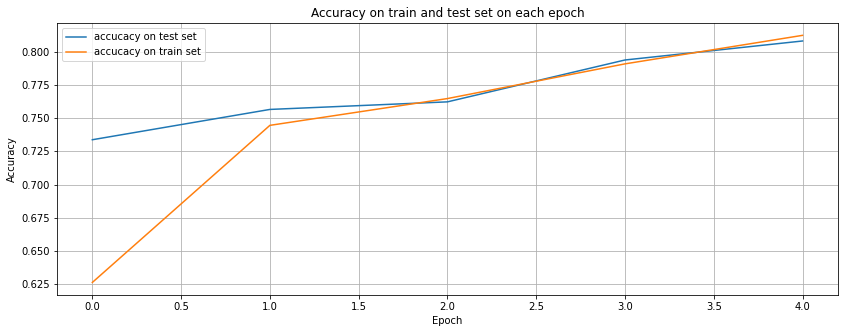

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=[14, 5])
plt.plot(accuracy_history_test, label='accucacy on test set')
plt.plot(accuracy_history_train, label='accucacy on train set')
plt.legend(loc='best')
plt.title('Accuracy on train and test set on each epoch')
plt.grid('True')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [13]:
model = model.eval()

In [14]:
torch.save(model, 'CIFAR10_ResNet18.pth')

In [15]:
def count_parameters(model): 
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [16]:
print('Num params in model after compression:', count_parameters(model))

Num params in model after compression: 11689512
